# Recreating images
Recreating the images from the paper [Phase diagram for two-layer ReLU neural networks at
infinite-width limit](https://arxiv.org/abs/2007.07497).

In [1]:
using LinearAlgebra, Printf
using Makie, CairoMakie

include("../MyTwoLayerNN/MyTwoLayerNN.jl")
import .MyTwoLayerNN

Global settings:

In [2]:
set_theme!(theme_latexfonts()) # Theme for plots 

Default data

In [3]:
d = 1 # Dimension of the data
dataX = [[-1/2], [-1/3], [1/3], [1/2]]
dataY = [0.25, 0.03, 0.03, 0.25]

4-element Vector{Float64}:
 0.25
 0.03
 0.03
 0.25

## Figure 2

For the scatter plot the amplitude and angle are calculated using:

Amplitude is calculated using: $A_i = |a_i|\cdot \|(w_i, b_i)\|_2$.

Angle is calculated using: $\phi_j = \arg(w_j + b_j\cdot i)$

In [59]:
function createlineplot(nn)
    # Initialize figure 
    f = Figure()
    ax = Axis(f[1, 1], xticks=-0.4:0.2:0.4)
    
    # Calculate points on the line 
    x = range(-0.5, 0.5, length=100)
    y = [MyTwoLayerNN.forward(myNN, p) for p in x]
    
    lines!(ax, x, y, color=:darkorange2)
    
    # Plot the points
    scatter!(ax, vcat(dataX...), dataY)
    
    return f
end

function createorientiationplot(nni, nnt)
    # Initialize figure 
    f = Figure()
    ax = Axis(f[1, 1], xticks=-3:1:3, xlabel="Orientation", ylabel="Amplitude")
    
    xlims!(ax, -π, π)
    
    # Calculate amplitude
    amp_initial = abs.(nni.a) .* norm.(eachrow([nni.w nni.b]))
    amp_trained = abs.(nnt.a) .* norm.(eachrow([nnt.w nnt.b]))
    
    # Calculate orientation
    ori_initial = angle.(vec(nni.w) + im * nni.b)
    ori_trained = angle.(vec(nnt.w) + im * nnt.b)
    
    # Plot all points
    scat_init = scatter!(ax, ori_initial, amp_initial, strokewidth=0.5)
    scat_trained = scatter!(ax, ori_trained, amp_trained, color=:darkorange2, strokewidth=0.5)
    
    axislegend(ax, [scat_init, scat_trained], ["Before training", "After training"])
    
    return f
end

createorientiationplot (generic function with 1 method)

### Experiments

In [107]:
# Creating the NN
m = 1_000
γ = 1.75
γ′ = 0.0
myNN = MyTwoLayerNN.TwoLayerNN(d, m, γ, γ′)

# Creating the training data
learning_rate = 10000.0
steps::Int32 = 800_000
myTrainingData = MyTwoLayerNN.TrainingData(dataX, dataY, learning_rate, steps)

# Create copy of initial weights and biases
initParms = (a = copy(myNN.a), w = copy(myNN.w), b = copy(myNN.b))

(a = [0.5982120032908713, -1.007534061728092, 1.9792329994168751, -0.3462198319016904, 1.2558982403338985, 0.03564654313687362, 0.8490240807518936, 0.9231296807572588, 0.9736674482047619, -0.3609524852394146  …  0.9232978930945667, -1.009848838189752, -0.022565232616764856, 0.6291710834882279, -0.09384507043038878, 0.03769774783468822, -1.55726472082453, -0.8471527767690751, -1.655290816517417, -1.8848309241990657], w = [0.8082879284649668; -1.1220725081141734; … ; -1.2505328746000024; -0.3463702447057351;;], b = [-1.2778929042682445, 1.3458458389777976, 0.5349715054489175, 1.7445216472908298, -0.94562442319331, -0.257833652705556, 1.0155900103675077, -0.9748654504001906, -0.5250116933467154, 1.3515697216872853  …  0.03839914442190294, -0.4111467572130697, -0.25802506459434893, -0.4435302225201445, -0.12243304520494255, 0.1320432249518399, -0.1891516619677945, 0.9918812907173121, 0.13715215788415805, 1.7066316447372152])

In [108]:
# Train the NN 
MyTwoLayerNN.train!(myNN, myTrainingData)

Number of steps: 6331


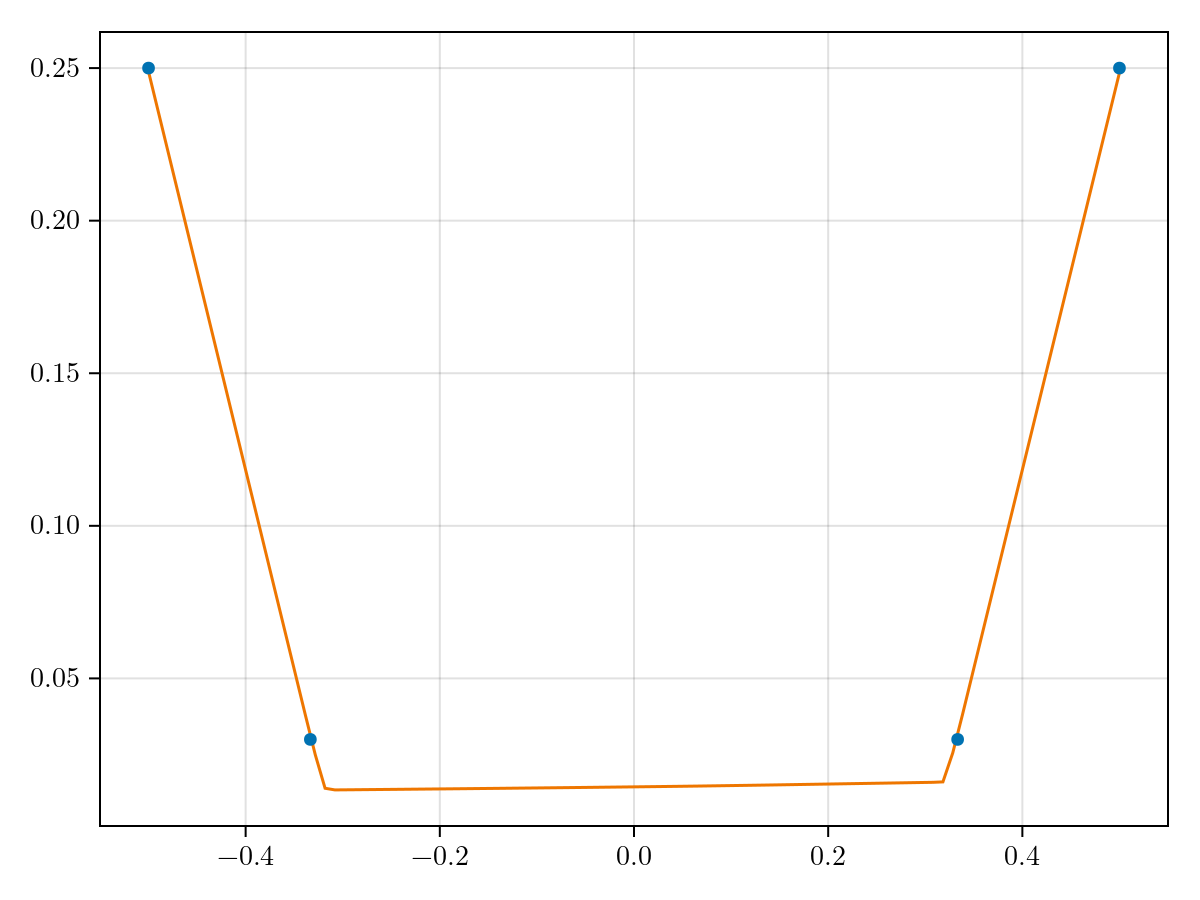

In [111]:
f = createlineplot(myNN)

f

In [50]:
save("line gamma=0.5 m=40000.pdf", f)

CairoMakie.Screen{PDF}


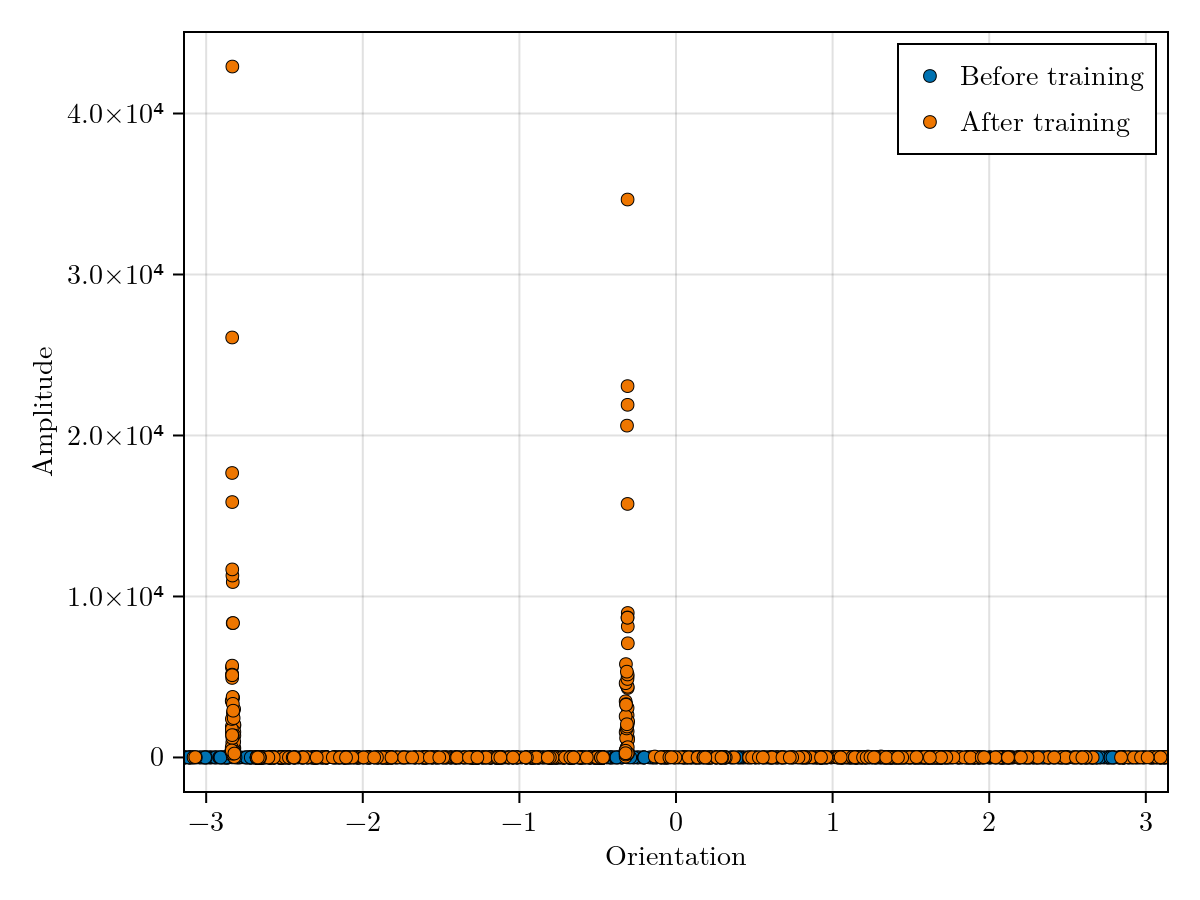

In [112]:
f = createorientiationplot(initParms, myNN)

In [52]:
save("orientation gamma=0.5 m=40000.pdf", f)

CairoMakie.Screen{PDF}


## Figure 3

$\text{RD}(\theta_w(t))=\frac{\|\theta_w(t)-\theta_w(0)\|_2}{\|\theta_w(0)\|_2}$

In [14]:
# Returns the relative distance between the inital parameters and the trained parameters
function RD(initial, trained)
    norm([trained.w; trained.b; trained.a] - [initial.w; initial.b; initial.a]) / norm([initial.w; initial.b; initial.a])
end

RD (generic function with 1 method)

In [15]:
hidden_layer_sizes = [1000, 5000, 10_000, 20_000, 40_000]

5-element Vector{Int64}:
  1000
  5000
 10000
 20000
 40000

In [18]:
# NN parameters
γ = 0.5
γ′ = 0.0

# Training data
learning_rate = 0.1 # For γ = 0.5, use 0.1, for γ = 1.0 use 100.0, for γ = 1.75 use 100_000.0
steps::Int32 = 200_000
myTrainingData = MyTwoLayerNN.TrainingData(dataX, dataY, learning_rate, steps)

RD_per_size = zeros(length(hidden_layer_sizes))

for (i, m) in enumerate(hidden_layer_sizes)
    # Create the NN
    myNN = MyTwoLayerNN.TwoLayerNN(d, m, γ, γ′)

    # Create copy of initial parameters
    initParms = (a = copy(myNN.a), w = copy(myNN.w), b = copy(myNN.b))

    # Train the NN
    MyTwoLayerNN.train!(myNN, myTrainingData)

    # Save the RD
    RD_per_size[i] = RD(initParms, myNN)
end

RD_per_size

Number of steps: 4507
Number of steps: 3043
Number of steps: 1873
Number of steps: 1580
Number of steps: 1526


5-element Vector{Float64}:
 0.031355910579107735
 0.011971753769764561
 0.009061705004831198
 0.007675501201773026
 0.007004101852276094

### Create plot

In [19]:
x = hidden_layer_sizes 
y = RD_per_size

xlog = log10.(x)
ylog = log10.(y)

# Determine trendline
X = [ones(eltype(x), length(x)) xlog]
offset, slope = inv(transpose(X) * X) * transpose(X) * ylog
fitted_line(x) = slope * x + offset

println("Line y = $slope x + $offset")

Line y = -0.41445708034320106 x + -0.32272822744464236


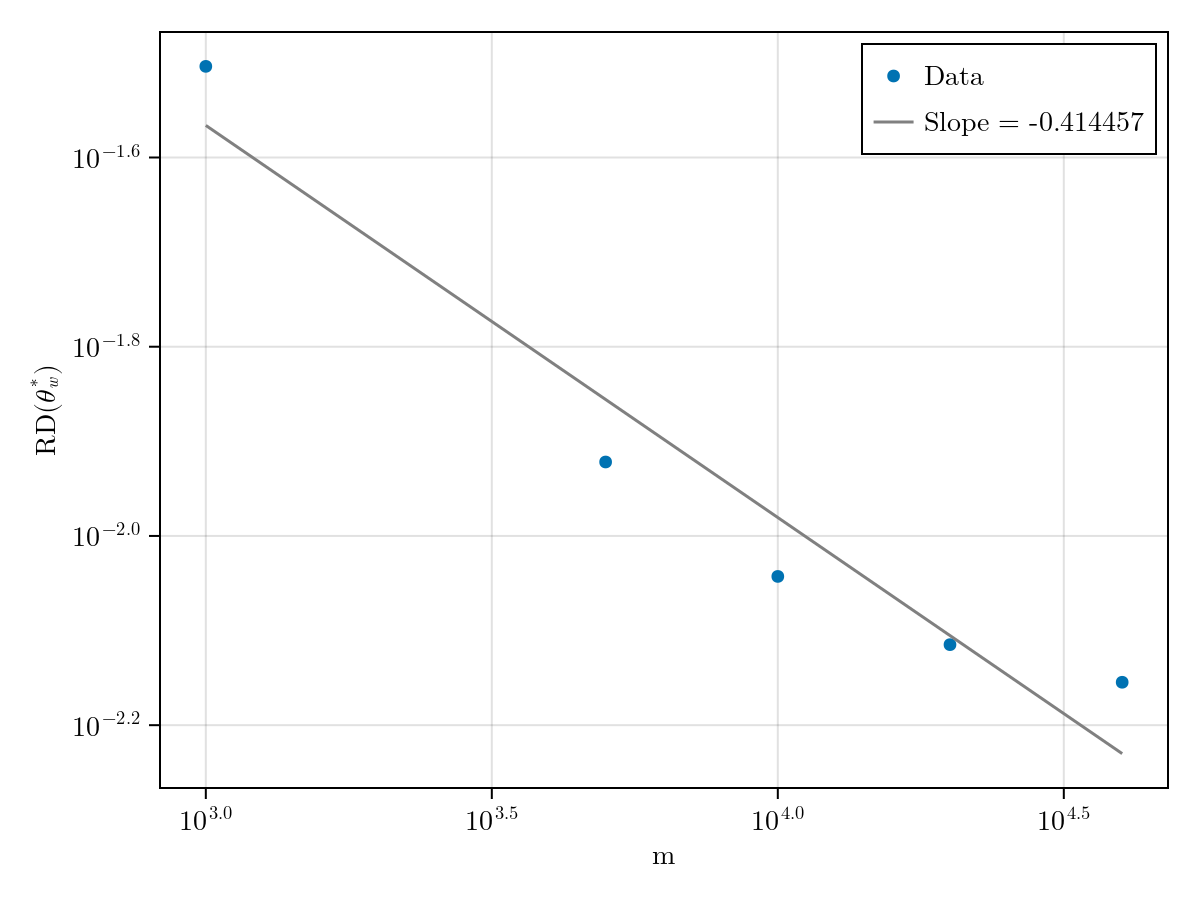

In [22]:
f = Figure()
ax = Axis(f[1, 1], xscale=log10, yscale=log10, xlabel="m", ylabel=L"RD(${\theta_w^*}$)")

mScat = scatter!(ax, x, y)
mLin = lines!(ax, [x[1], x[end]], [10^fitted_line(xlog[1]), 10^fitted_line(xlog[end])], color=:gray)
axislegend(ax, [mScat, mLin], ["Data", @sprintf "Slope = %f" slope], position=:rt)

# ylims!(ax, 10, 100)

f

In [177]:
save("Growth RD gamma 1.75.pdf", f)

CairoMakie.Screen{PDF}


# Other images

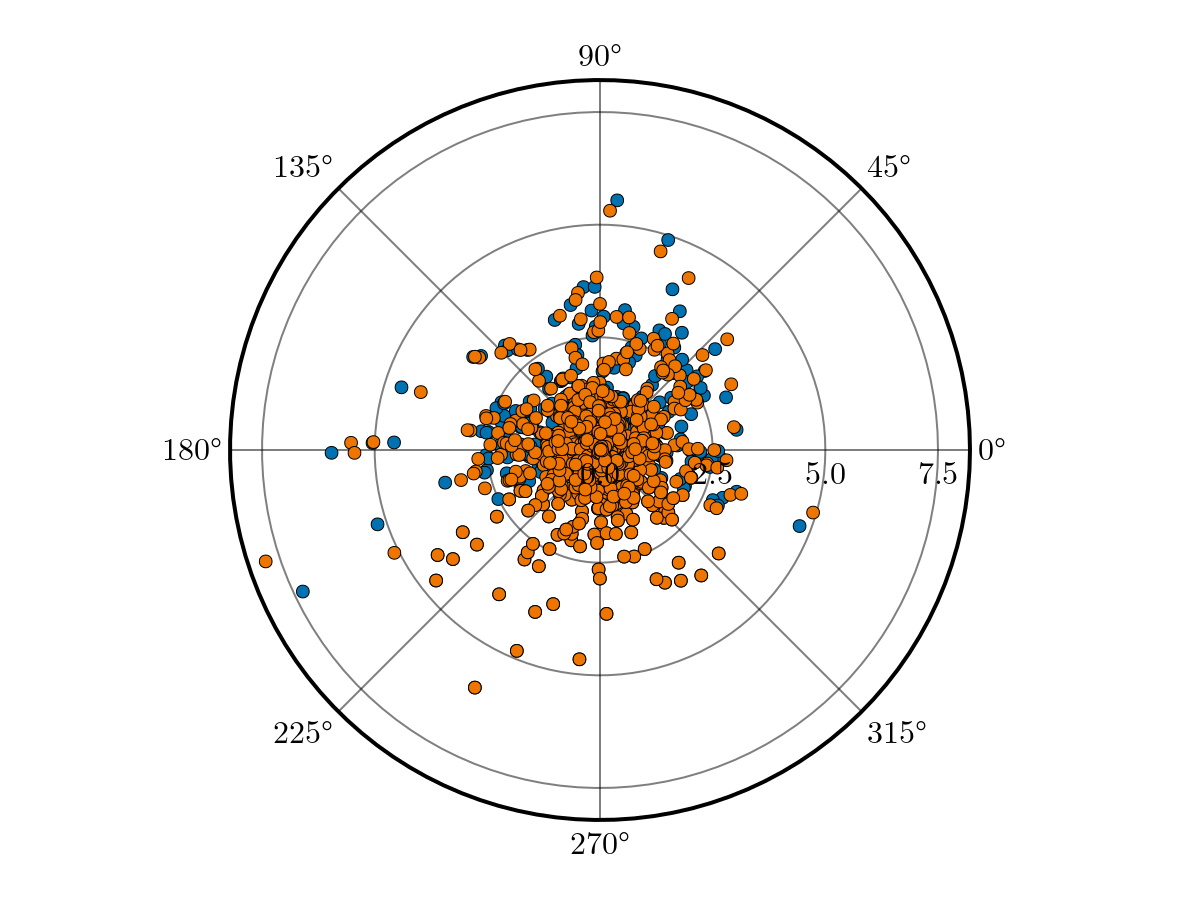

In [84]:
f = Figure()
ax = PolarAxis(f[1, 1])

scatter!(ax, oriInit, ampInit, strokewidth=0.5)
scatter!(ax, oriNew, ampNew, color=:darkorange2, strokewidth=0.5)

f

## Inflection points 

For $\text{ReLu}(w_k^\intercal x + b_k)$ the inflection point is at $x = -\frac{b_k}{w_k}$.

In [68]:
function inflectionpoints(nn)
    return vec(-1 .* nn.b ./ nn.w)
end

inflectionpoints (generic function with 1 method)

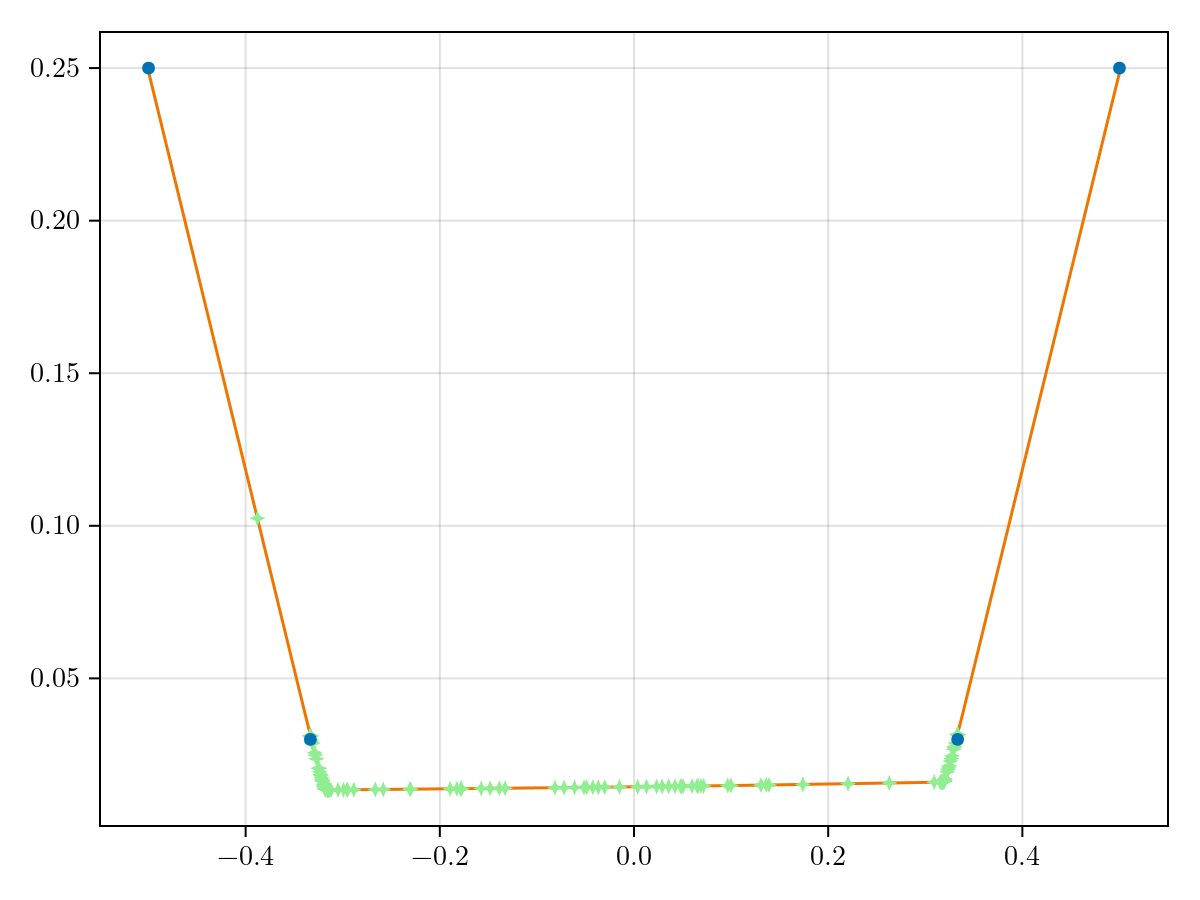

In [109]:
# Initialize figure 
f = Figure()
ax = Axis(f[1, 1], xticks=-0.4:0.2:0.4)

# Calculate points on the line 
x = range(-0.5, 0.5, length=100)
y = [MyTwoLayerNN.forward(myNN, p) for p in x]

lines!(ax, x, y, color=:darkorange2)

# Calculate inflection points
x_inflection_points = filter(e -> e ≥ -0.5 && e ≤ 0.5, inflectionpoints(myNN))
y_inflection_points = [MyTwoLayerNN.forward(myNN, p) for p in x_inflection_points]

scatter!(ax, x_inflection_points, y_inflection_points, marker=:star4, color=:lightgreen)

# Plot the data points
scatter!(ax, vcat(dataX...), dataY)

f